In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
data = pd.read_csv('marathon-data.csv')
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


### Terminology

* Splits= a race or run’s total time divided into parts (usually km or miles)
* Negative split= running the second half of a race faster than the first half; ideal way to pace most races
* Positive split= running the second half of the race slower than the first half
* Even split= running the first and second half of a race at a consistent pace

In [19]:
""" By default, Pandas loaded the time columns as Python strings (type object); we can 
see this by looking at the dtypes attribute of the DataFrame:"""
data.dtypes

age                     int64
gender                 object
split         timedelta64[ns]
final         timedelta64[ns]
split_sec             float64
final_sec             float64
split_frac            float64
age_dec                 int64
dtype: object

In [20]:
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return pd.datetools.timedelta(hours=h, minutes=m, seconds=s)
data = pd.read_csv('marathon-data.csv', converters={'split':convert_time, 'final':convert_time})
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [21]:
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

In [8]:
"""That looks much better. For the purpose of our Seaborn plotting utilities, let’s next
add columns that give the times in seconds:"""

data['split_sec'] = data['split'] / np.timedelta64(1, 's')
data['final_sec'] = data['final'] / np.timedelta64(1, 's')
data.head()

,age,gender,split,final,split_sec,final_sec
0,33,M,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,4009.0,7842.0
3,38,M,01:06:16,02:13:45,3976.0,8025.0
4,31,M,01:06:32,02:13:59,3992.0,8039.0


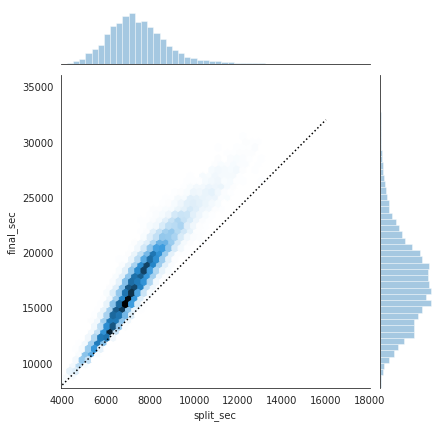

In [9]:
# To get an idea of what the data looks like, we can plot a jointplot over the data
with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", data, kind='hex')
    g.ax_joint.plot(np.linspace(4000, 16000), np.linspace(8000, 32000), ':k')

### Observations
The dotted line shows where someone’s time would lie if they ran the marathon at a
perfectly steady pace. The fact that the distribution lies above this indicates (as you
might expect) that most people slow down over the course of the marathon.

In [10]:
"""Let’s create another column in the data, the split fraction, which measures the degree
to which each runner negative-splits or positive-splits the race:"""
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842


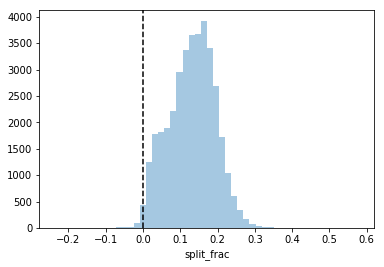

In [11]:
"""Where this split difference is less than zero, the person negative-split the race by that
fraction. Let’s do a distribution plot of this split fraction """
In[30]: sns.distplot(data['split_frac'], kde=False);
plt.axvline(0, color="k", linestyle="--");

In [12]:
sum(data.split_frac < 0)

251

Out of nearly 40,000 participants, there were only 250 people who negative-split their
marathon.
Let’s see whether there is any correlation between this split fraction and other variables.
We’ll do this using a pairgrid, which draws plots of all these correlations

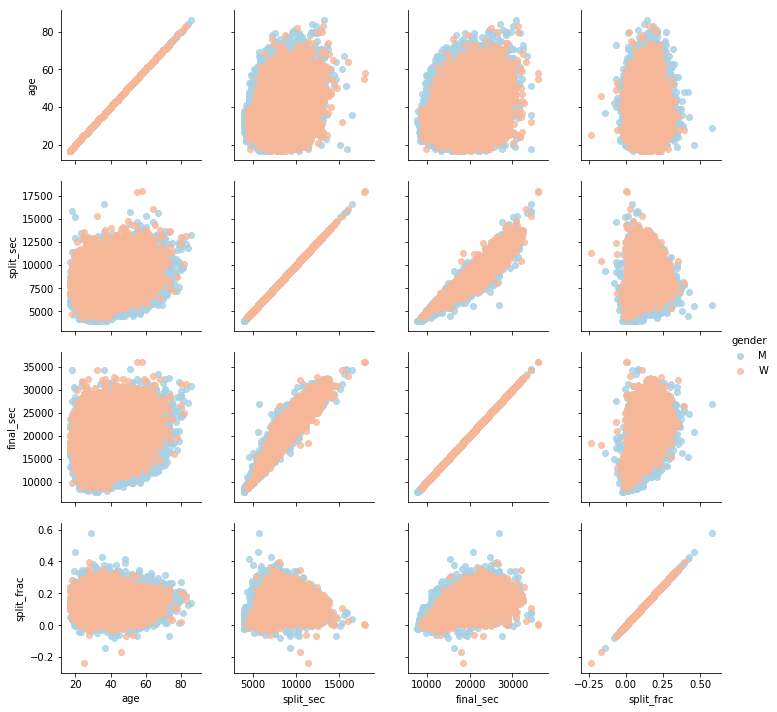

In [13]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'],
hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

### Observations
It looks like the split fraction does not correlate particularly with age, but does correlate
with the final time: faster runners tend to have closer to even splits on their marathon
time.

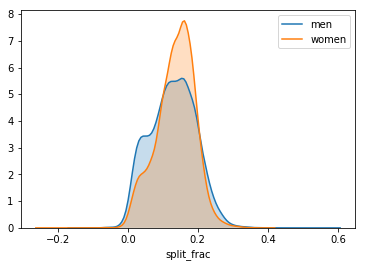

In [14]:
"""The difference between men and women here is interesting. Let’s look at the histogram
of split fractions for these two groups"""
In[33]: sns.kdeplot(data.split_frac[data.gender=='M'], label='men', shade=True)
sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
plt.xlabel('split_frac');

The interesting thing here is that there are many more men than women who are
running close to an even split! This almost looks like some kind of bimodal distribution
among the men and women.

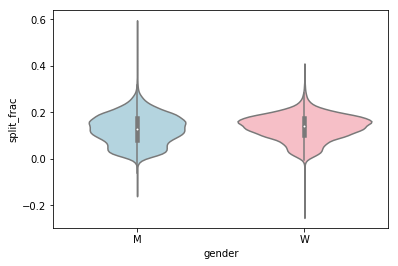

In [15]:
#nice way to compare distributions is to use a violin plot
sns.violinplot("gender", "split_frac", data=data,
palette=["lightblue", "lightpink"]);

This is yet another way to compare the distributions between men and women.
Let’s look a little deeper, and compare these violin plots as a function of age. We’ll
start by creating a new column in the array that specifies the decade of age that each
person is in

In [16]:
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097,30
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842,30


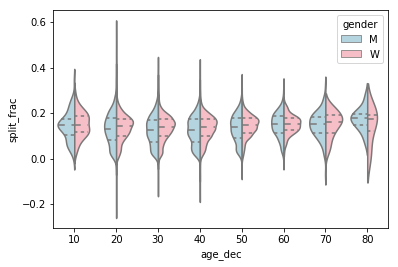

In [17]:
men = (data.gender == 'M')
women = (data.gender == 'W')
with sns.axes_style(style=None):
    sns.violinplot("age_dec", "split_frac", hue="gender", data=data,
    split=True, inner="quartile", palette=["lightblue", "lightpink"]);

Looking at this, we can see where the distributions of men and women differ: the split
distributions of men in their 20s to 50s show a pronounced over-density toward
lower splits when compared to women of the same age (or of any age, for that
matter).

### Back to the men with negative splits: who are these runners? Does this split fraction correlate with finishing quickly? We can plot this very easily. We’ll use regplot, which will automatically fit a linear regression to the data

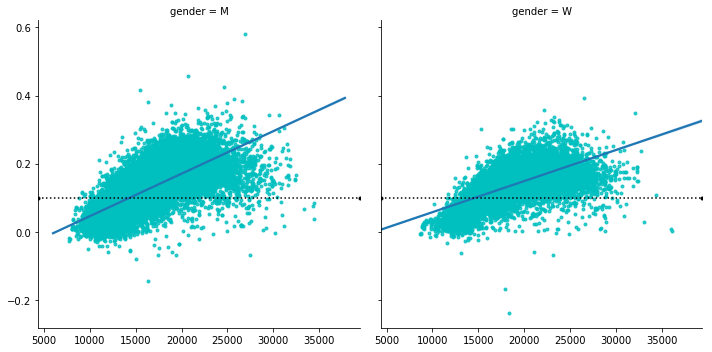

In [18]:
g = sns.lmplot('final_sec', 'split_frac', col='gender', data=data,
markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");

Apparently the people with fast splits are the elite runners who are finishing within
~15,000 seconds, or about 4 hours. People slower than that are much less likely to
have a fast second split.